In [173]:
import networkx as nx
import random
import os
import matplotlib.pyplot as plt
import baseGrafo
from typing import Dict, List, Tuple
from utils import ler_grafo_dimacs, ler_solucoes_otimas, salvar_resultados

vertices:  40 
arestas:  244


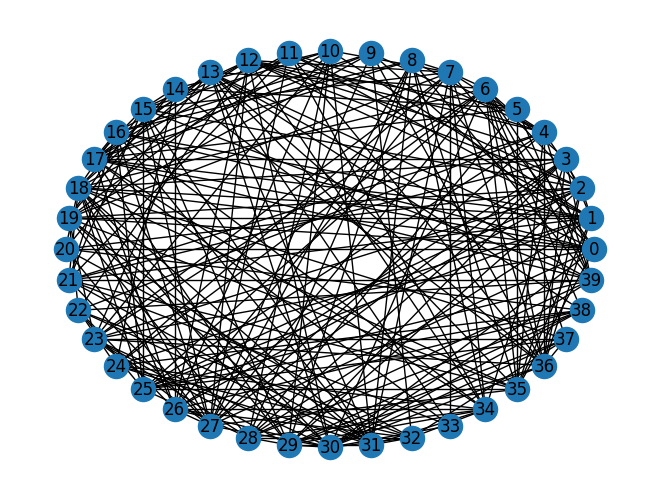

In [ ]:
#baseGrafo.grafoImport(40)

3328


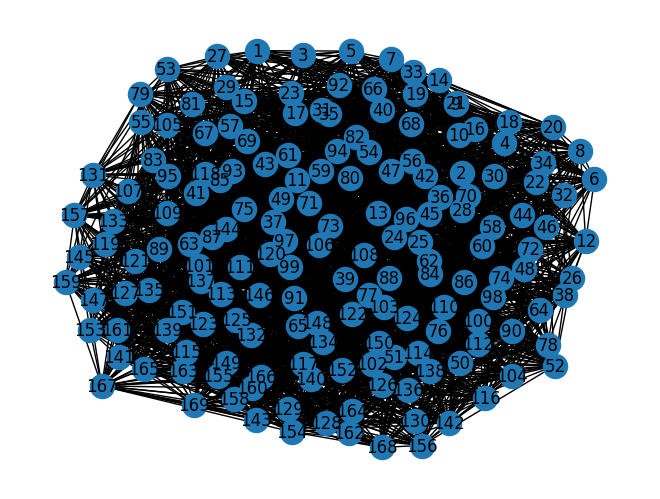

In [182]:
pasta_grafos = "grafos"
resultados_dir = "resultados"
os.makedirs(resultados_dir, exist_ok=True)

solucoes_otimas = ler_solucoes_otimas("solucoes_otimas.csv")

G = ler_grafo_dimacs(os.path.join("grafos", "queen13_13.col"))
print(G.number_of_edges())
nx.draw(G, with_labels=True)      

[6, 19, 20, 23, 35, 1, 11, 12, 25, 36, 4, 15, 26, 29]


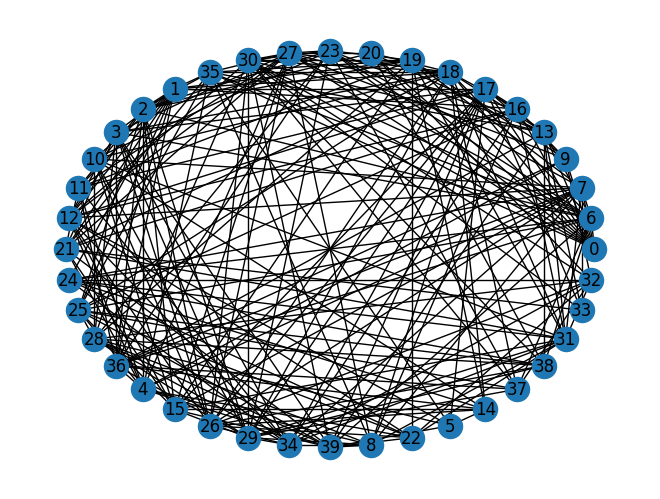

In [175]:
G = nx.read_edgelist("grafoBase.csv", delimiter=",")
G = nx.relabel_nodes(G, lambda x: int(x))
print(list(G.neighbors(2)))

nx.draw_circular(G, with_labels=True)

In [177]:
def calcular_conflitos(G: nx.Graph, coloracao: Dict[int, int]) -> int:
    """Calcula o número de arestas com vértices da mesma cor."""
    conflitos = 0
    for u, v in G.edges():
        if coloracao[u] == coloracao[v]:
            conflitos += 1
    return conflitos

def calcular_custo_delta(G: nx.Graph, coloracao: Dict[int, int], custo_atual: int, v: int, nova_cor: int) -> int:
    """Calcula o novo custo após mover o vértice v para nova_cor, de forma eficiente."""
    cor_antiga = coloracao[v]
    novo_custo = custo_atual

    # Itera apenas sobre os vizinhos do vértice que mudou de cor
    for vizinho in G.neighbors(v):
        # 1. Subtrai os conflitos que foram removidos
        if coloracao[vizinho] == cor_antiga:
            novo_custo -= 1
        # 2. Adiciona os novos conflitos que foram criados
        if coloracao[vizinho] == nova_cor:
            novo_custo += 1
            
    return novo_custo

def busca_tabu_coloracao(G: nx.Graph, max_iter: int, tabu_tamanho: int, n_cores: int, solucao_inicial: Dict[int, int]):
    """
    Executa a Busca Tabu com DIVERSIFICAÇÃO e avaliação DELTA (muito mais rápido).
    """
    # --- Parâmetros ---
    paciencia = max_iter // 4
    iter_sem_melhora = 0
    
    atual_coloracao = solucao_inicial.copy()
    
    # Ajusta a solução inicial para o k_alvo
    if (max(atual_coloracao.values()) if atual_coloracao else -1) >= n_cores:
        for v, c in atual_coloracao.items():
            atual_coloracao[v] = c % n_cores
    
    custo_atual = calcular_conflitos(G, atual_coloracao)
    
    melhor_coloracao = atual_coloracao.copy()
    melhor_custo_global = custo_atual
    lista_tabu = []

    if melhor_custo_global == 0:
        return melhor_coloracao, 0

    for i in range(max_iter):
        # Lógica de Diversificação
        if iter_sem_melhora >= paciencia:
            print(f"      -> Diversificando... (sem melhora por {paciencia} iterações)")
            atual_coloracao = {v: random.randint(0, n_cores - 1) for v in G.nodes()}
            custo_atual = calcular_conflitos(G, atual_coloracao)
            lista_tabu = []
            iter_sem_melhora = 0
            if custo_atual < melhor_custo_global:
                melhor_custo_global = custo_atual
                melhor_coloracao = atual_coloracao.copy()
                if melhor_custo_global == 0: break
        
        # ### MUDANÇA CRÍTICA: Avaliação de vizinhança "on-the-fly" ###
        melhor_movimento = None
        melhor_custo_vizinho = float('inf')

        # Identifica os nós com conflito para focar a busca
        nos_conflitantes = {u for u, v in G.edges() if atual_coloracao[u] == atual_coloracao[v]} | \
                           {v for u, v in G.edges() if atual_coloracao[u] == atual_coloracao[v]}

        if not nos_conflitantes:
            break # Solução encontrada

        # Itera sobre os MOVIMENTOS possíveis, não sobre vizinhos materializados
        for v_conflitante in nos_conflitantes:
            cor_antiga = atual_coloracao[v_conflitante]
            for nova_cor in range(n_cores):
                if nova_cor == cor_antiga:
                    continue

                # Calcula o custo do movimento de forma barata
                custo_movimento = calcular_custo_delta(G, atual_coloracao, custo_atual, v_conflitante, nova_cor)
                
                movimento = (v_conflitante, nova_cor)
                
                # Critério de Aspiração + Verificação Tabu
                is_tabu = movimento in lista_tabu
                if (not is_tabu) or (custo_movimento < melhor_custo_global):
                    if custo_movimento < melhor_custo_vizinho:
                        melhor_custo_vizinho = custo_movimento
                        melhor_movimento = movimento
        
        if melhor_movimento is None:
            break # Não encontrou nenhum movimento válido

        # ### Aplica APENAS o melhor movimento encontrado ###
        vertice_movido, nova_cor_movida = melhor_movimento
        cor_antiga_movida = atual_coloracao[vertice_movido]
        
        # Atualiza a coloração e o custo
        atual_coloracao[vertice_movido] = nova_cor_movida
        custo_atual = melhor_custo_vizinho
        
        # Adiciona o movimento reverso à lista tabu (uma prática comum e eficaz)
        movimento_tabu = (vertice_movido, cor_antiga_movida)
        lista_tabu.append(movimento_tabu)
        if len(lista_tabu) > tabu_tamanho:
            lista_tabu.pop(0)

        # Atualiza a melhor solução global se necessário
        if custo_atual < melhor_custo_global:
            melhor_coloracao = atual_coloracao.copy() # Copia apenas quando melhora
            melhor_custo_global = custo_atual
            iter_sem_melhora = 0
            if melhor_custo_global == 0:
                break
        else:
            iter_sem_melhora += 1
            
    return melhor_coloracao, melhor_custo_global

In [178]:
def otimizar_com_busca_tabu(G: nx.Graph, solucao_inicial: Dict[int, int], k_inicial: int, max_iter: int, tabu_tamanho: int):
    """
    Recebe uma solução gulosa e tenta diminuir o número de cores (k)
    usando a Busca Tabu de forma decremental.
    """
    melhor_k_geral = k_inicial
    melhor_coloracao_geral = solucao_inicial.copy()
    print("-" * 30)
    print(f"Iniciando otimização da Busca Tabu com k = {k_inicial - 1}")
    print("-" * 30)
    
    # Loop decremental: começa de k_inicial - 1 e vai até 1
    for k_alvo in range(k_inicial - 1, 0, -1):
        print(f"\n[Tentativa] Buscando solução com {k_alvo} cores...")
        
        coloracao, conflitos = busca_tabu_coloracao(
            G, max_iter, tabu_tamanho, n_cores=k_alvo, solucao_inicial=melhor_coloracao_geral
        )
        
        if conflitos == 0:
            print(f"  -> SUCESSO! Solução válida encontrada com {k_alvo} cores.")
            melhor_k_geral = k_alvo
            melhor_coloracao_geral = coloracao.copy()
        else:
            print(f"  -> FALHA. Não foi possível encontrar solução com {k_alvo} cores.")
            print("      Parando a busca e retornando a melhor solução anterior.")
            break # Se falhou, não adianta tentar com menos cores

    return melhor_k_geral, melhor_coloracao_geral

In [ ]:
def executar_completo():
    """Orquestra todo o processo de coloração de grafos."""
    # --- Parâmetros ---
    #NUM_VERTICES = 20
    MAX_ITER_TABU = 100000
    TAMANHO_LISTA_TABU = 1000

    # 1. Gerar o grafo (Apenas caso para teste, agora estamos usando o baseGrafo)
    #G = grafoImport(NUM_VERTICES)


    # 2. Obter solução inicial com heurística gulosa
    solucao_gulosa, k_guloso = baseGrafo.heuristicaGulosa(G)
    conflitos_gulosos = calcular_conflitos(G, solucao_gulosa)
    print("\n--- Resultado da Heurística Gulosa ---")
    print(f"Número de cores usado: {k_guloso}")
    print(f"Conflitos iniciais: {conflitos_gulosos}")

    # 3. Otimizar a solução com a Busca Tabu (estratégia decremental)
    k_final, coloracao_final = otimizar_com_busca_tabu(
        G, solucao_gulosa, k_guloso, MAX_ITER_TABU, TAMANHO_LISTA_TABU
    )

    # 4. Imprimir resultados finais
    print("\n" + "=" * 30)
    print("--- Resultado Final da Busca Tabu ---")
    print(f"Número mínimo de cores encontrado: {k_final}")
    print("Coloração final dos vértices:")
    print(sorted(coloracao_final.items()))

    # 5. Visualização
    pos = nx.spring_layout(G, seed=42)
    cores_map = [coloracao_final.get(v, 0) for v in G.nodes()]
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color=cores_map, cmap=plt.cm.jet, node_size=800, font_color='white')
    plt.title(f'Coloração Final com {k_final} cores (sem conflitos)')
    plt.show()

# Executar tudo
executar_completo()

169

--- Resultado da Heurística Gulosa ---
Número de cores usado: 20
Conflitos iniciais: 0
------------------------------
Iniciando otimização da Busca Tabu com k = 19
------------------------------

[Tentativa] Buscando solução com 19 cores...
  -> SUCESSO! Solução válida encontrada com 19 cores.

[Tentativa] Buscando solução com 18 cores...
  -> SUCESSO! Solução válida encontrada com 18 cores.

[Tentativa] Buscando solução com 17 cores...
  -> SUCESSO! Solução válida encontrada com 17 cores.

[Tentativa] Buscando solução com 16 cores...
  -> SUCESSO! Solução válida encontrada com 16 cores.

[Tentativa] Buscando solução com 15 cores...
